In [1]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()
print (len(objpoints))
print (len(imgpoints))

17
17


In [12]:
# Make a list of calibration images

i=0
# Step through the list and search for chessboard corners
for fname in os.listdir("camera_cal/"):
    img1 = "camera_cal/" + fname
    img = cv2.imread(img1)
    objp = np.zeros((5*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,5),None)

    # If found, add object points, image points
    if ret == True:
        i=i+1
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img2 = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Undistort using mtx and dist
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        # Using camera_undistort dir for undistorted image output
        try:
            if not os.path.exists("camera_undistort"):
                os.makedirs("camera_undistort")
            file_suffix = os.path.splitext(fname)[1]
            file_name = os.path.splitext(fname)[0]
            filename = '{}{}{}{}'.format("camera_undistort", os.sep, file_name, file_suffix)
            cv2.imwrite(filename, undist)
        except IOError as e:
            print("IOError")
        except Exception as e:
            print("Exception")
print (i)

1


In [23]:
# Apply a distortion correction to raw images
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Find the chessboard corners 
    return undist

for fname in os.listdir("test_images/"):
    img1 = "test_images/" + fname
    img = cv2.imread(img1)
    undist = cal_undistort(img, objpoints, imgpoints)
    # Using camera_undistort dir for undistorted image output
    try:
        if not os.path.exists("output_images"):
            os.makedirs("output_images")
        file_suffix = os.path.splitext(fname)[1]
        file_name = os.path.splitext(fname)[0]
        filename = '{}{}{}{}'.format("output_images", os.sep, file_name, file_suffix)
        cv2.imwrite(filename, undist)
    except IOError as e:
        print("IOError")
    except Exception as e:
        print("Exception")



In [3]:
import os
import numpy as np
import cv2
import glob
import matplotlib
matplotlib.use('Qt4Agg')
from matplotlib import pyplot as plt
# Use color transforms, gradients, etc., to create a thresholded binary image
def col_grad2bin(img):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Convert to grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)    
    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    plt.show()
    return combined_binary

for fname in os.listdir("output_images/"):
    img1 = "output_images/" + fname
    img = cv2.imread(img1)
    combined_binary = col_grad2bin(img)
    


In [5]:
# Apply a perspective transform to rectify binary image ("birds-eye view")
def corners_unwarp(binary_img): 
    img_size = (binary_img.shape[1], binary_img.shape[0])
    # For source points I chose four points
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    # For destination points I chose four points
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(binary_img, M, img_size)
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Original Binary_image')
    ax1.imshow(binary_img, cmap='gray')    
    ax2.set_title('Undistorted and Warped Image')
    ax2.imshow(warped, cmap='gray')
    plt.show()
    return warped

for fname in os.listdir("output_images/"):
    img1 = "output_images/" + fname
    img = cv2.imread(img1)
    combined_binary = col_grad2bin(img)
    warped = corners_unwarp(combined_binary)
    

In [2]:
eps = 0.000001
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

class LaneBoundary:
    def __init__(self, left_fit, right_fit, left_fit_cr, right_fit_cr):
        self.lfit = left_fit
        self.rfit = right_fit
        self.clfit = left_fit_cr
        self.crfit = right_fit_cr
        
    def weighted_img(self, img, initial_img, α=0.8, β=1., γ=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.

        `initial_img` should be the image before any processing.

        The result image is computed as follows:

        initial_img * α + img * β + γ
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, α, img, β, γ)

    # Apply a distortion correction to raw images
    def cal_undistort2(self, img, objpoints, imgpoints):
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        # Find the chessboard corners 
        return undist

    # Use color transforms, gradients, etc., to create a thresholded binary image
    def col_grad2bin2(self, img):
        # Convert to HLS color space and separate the S channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        # Convert to grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
        abs_sobelx = np.absolute(sobelx) 
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        # Threshold x gradient
        thresh_min = 20
        thresh_max = 100
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        # Threshold color channel
        s_thresh_min = 170
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

        return combined_binary

    # Apply a perspective transform to rectify binary image ("birds-eye view")
    def corners_unwarp2(self, binary_img): 
        img_size = (binary_img.shape[1], binary_img.shape[0])
        # For source points I chose four points
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        # For destination points I chose four points
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(binary_img, M, img_size)

        return warped

    # Warp the detected lane boundaries back onto the original image
    def decorners_unwarp2(self, binary_img): 
        img_size = (binary_img.shape[1], binary_img.shape[0])
        # For source points I chose four points
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        # For destination points I chose four points
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])

        Minv = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(binary_img, Minv, img_size)

        return warped

    def find_lane_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img

    def fit_polynomial(self, binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)

        # Fit a second order polynomial to each using `np.polyfit`
        self.lfit = np.polyfit(lefty, leftx, 2)
        self.rfit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = self.lfit[0]*ploty**2 + self.lfit[1]*ploty + self.lfit[2]
            right_fitx = self.rfit[0]*ploty**2 + self.rfit[1]*ploty + self.rfit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        self.clfit = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        self.crfit = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2) 

        #out_img = out_img*255
        window_img = np.zeros_like(out_img)
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        line_pts = np.hstack((left_line_window, right_line_window))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        return result

    def fit_poly(self, img_shape, leftx, lefty, rightx, righty):
        # Fit a second order polynomial to each with np.polyfit() 
        self.lfit = np.polyfit(lefty, leftx, 2)
        self.rfit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        # Calc both polynomials using ploty, left_fit and right_fit 
        left_fitx = self.lfit[0]*ploty**2 + self.lfit[1]*ploty + self.lfit[2]
        right_fitx = self.rfit[0]*ploty**2 + self.rfit[1]*ploty + self.rfit[2]

        self.clfit = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        self.crfit = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

        return left_fitx, right_fitx, ploty

    # Detect lane pixels and fit to find the lane boundary
    def search_around_poly(self, binary_warped):
        # Choose the width of the margin around the previous polynomial to search
        margin = 100
        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        if (abs(self.lfit[0])<=eps and abs(self.lfit[1])<=eps and abs(self.lfit[2])<=eps) or (abs(self.rfit[0])<=eps and abs(self.rfit[1])<=eps and abs(self.rfit[2])<=eps):
            #print ("yes")
            result = self.fit_polynomial(binary_warped)
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
            return result, ploty
        else:
            #print ("no")
            left_lane_inds = ((nonzerox > (self.lfit[0]*(nonzeroy**2) + self.lfit[1]*nonzeroy + 
                            self.lfit[2] - margin)) & (nonzerox < (self.lfit[0]*(nonzeroy**2) + 
                            self.lfit[1]*nonzeroy + self.lfit[2] + margin)))
            right_lane_inds = ((nonzerox > (self.rfit[0]*(nonzeroy**2) + self.rfit[1]*nonzeroy + 
                            self.rfit[2] - margin)) & (nonzerox < (self.rfit[0]*(nonzeroy**2) + 
                            self.rfit[1]*nonzeroy + self.rfit[2] + margin)))

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]

            # Fit new polynomials
            left_fitx, right_fitx, ploty = self.fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            line_pts = np.hstack((left_line_window, right_line_window))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

            # Plot the polynomial lines onto the image
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')

            return result, ploty
    
    def process_image(self, image):
        undist = self.cal_undistort2(image, objpoints, imgpoints)
        binary_img = self.col_grad2bin2(undist)
        warped = self.corners_unwarp2(binary_img)

        result, ploty = self.search_around_poly(warped)
        # Determine the curvature of the lane 
        y_eval = np.max(ploty) 
        # Calculation of R_curve (radius of curvature)
        try:
            left_curverad = ((1 + (2*self.clfit[0]*y_eval*ym_per_pix + self.clfit[1])**2)**1.5) / np.absolute(2*self.clfit[0])
            right_curverad = ((1 + (2*self.crfit[0]*y_eval*ym_per_pix + self.crfit[1])**2)**1.5) / np.absolute(2*self.crfit[0])
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('nihao')
            left_curverad = 0.0
            right_curverad = 0.0
        curverad = (left_curverad+right_curverad)/2
        # Determine vehicle position with respect to center
        histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        vehicle = abs(600-(leftx_base+rightx_base)/2)

        # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
        text_curverad=str(curverad)
        text_vehicle=str(vehicle)
        mytext = "lane curvature is" + text_curverad + " and vehicle position is" + text_vehicle

        # Warp the detected lane boundaries back onto the original image
        result = self.decorners_unwarp2(result)
        result = self.weighted_img(result, undist)
        font=cv2.FONT_HERSHEY_SIMPLEX
        res=cv2.putText(result,mytext,(100,100),font,1.0,(255,0,0),2)
        return res

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video videos_output/project_video.mp4
[MoviePy] Writing video videos_output/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [21:21<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/project_video.mp4 

Wall time: 21min 23s


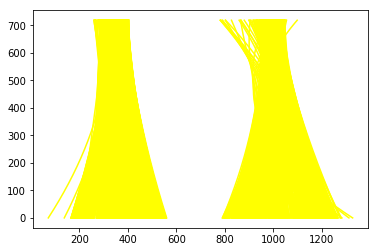

In [4]:
left_fit = np.zeros((3,), dtype=np.float32)
right_fit = np.zeros((3,), dtype=np.float32)
left_fit_cr = np.zeros((3,), dtype=np.float32)
right_fit_cr = np.zeros((3,), dtype=np.float32)
detect_lane = LaneBoundary(left_fit, right_fit, left_fit_cr, right_fit_cr)

if not os.path.exists("videos_output"):
    os.makedirs("videos_output")
white_output = 'videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detect_lane.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))